In [1]:
from scipy.stats import poisson

In [2]:
lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_discrete_frozen

In [3]:
k = 4
dist.pmf(k)

np.float64(0.039471954028253146)

In [4]:
from empiricaldist import Pmf

In [ ]:
def make_poisson_pmf(lam, qs):
    ps = poisson(lam).pmf(qs) #qs would be like different values of k from above - the goals
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [7]:
import numpy as np

In [8]:
lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)


In [68]:
pmf_goals

,probs
0,0.246598
1,0.345237
2,0.241666
3,0.112777
4,0.039472
5,0.011052
6,0.002579
7,0.000516
8,0.000090
9,0.000014


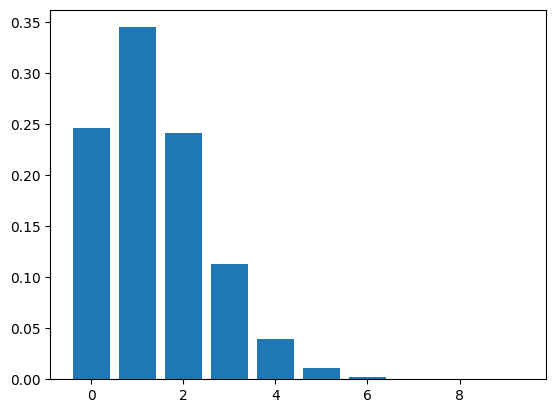

In [ ]:
# this tells us, for a given goal scoring rate, we can predict the number of goals
pmf_goals.bar()

In [12]:
# question is can we do the reverse, given the number of goals can we find the goal scoring rate?
# To answer that, we need to think about the prior distribution of lam, 
# which represents the range of possible values and their probabilities before we see the score.

8.3. The Gamma Distribution

To model the distribution of goal-scoring rates (lam), I’ll use a gamma distribution, which I chose because:

    The goal scoring rate is continuous and non-negative, and the gamma distribution is appropriate for this kind of quantity.

    The gamma distribution has only one parameter, alpha, which is the mean. So it’s easy to construct a gamma distribution with the mean we want.

    As we’ll see, the shape of the gamma distribution is a reasonable choice, given what we know about soccer.


In [13]:
from scipy.stats import gamma

In [ ]:
alpha = 1.4 # mean of 1.4 since you can find the average number of goals for all games
qs = np.linspace(0, 10, 101) #possible values of lam.
ps = gamma(alpha).pdf(qs)

In [63]:
prior = Pmf(ps, qs)
prior.normalize()

np.float64(9.889360237140306)

In [64]:
prior

,probs
0.0,0.000000
0.1,0.041053
0.2,0.049015
0.3,0.052160
0.4,0.052952
...,...
9.6,0.000019
9.7,0.000017
9.8,0.000016
9.9,0.000014


<Axes: >

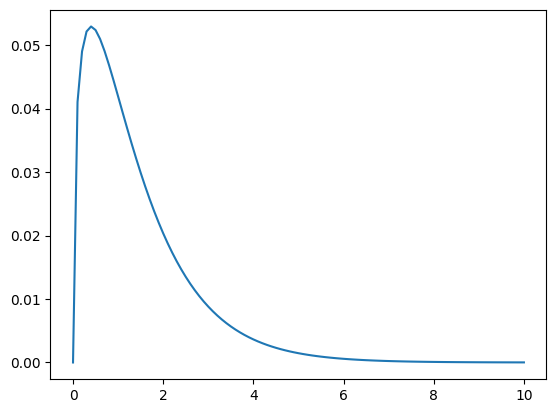

In [21]:
prior.plot()

8.4. The Update

In [22]:
# if we know lam, then to get the probability of k goals we do
lam = 1.4
k = 4
poisson(lam).pmf(k)

np.float64(0.039471954028253146)

In [23]:
# if intead we have an array of lam
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

In [24]:
# turn the above into a function
def update_poisson(pmf, data):
    k = data # number of goals
    lams = pmf.qs # hypos
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()


In [25]:
france = prior.copy()
update_poisson(france, 4)

In [30]:
from utils import decorate
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

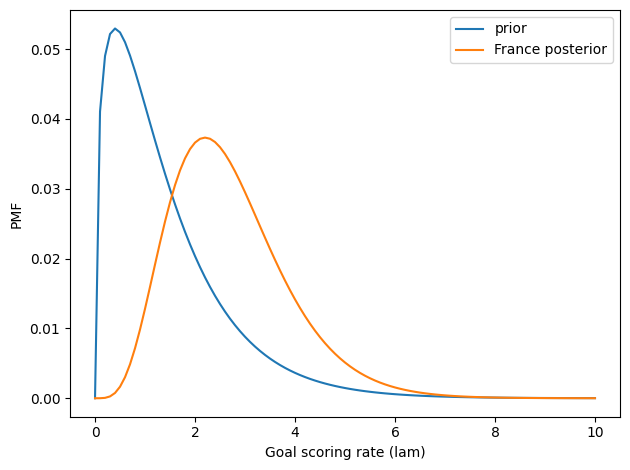

In [32]:
prior.plot(label='prior')
france.plot(label='France posterior')
decorate_rate()

In [33]:
croatia = prior.copy()
update_poisson(croatia, 2)

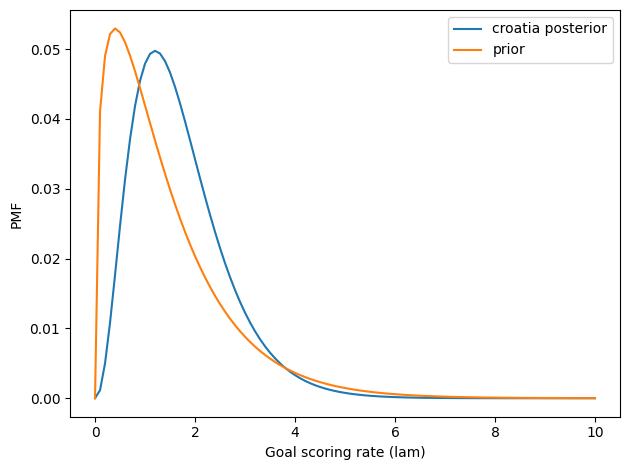

In [35]:
croatia.plot(label='croatia posterior')
prior.plot(label='prior')
decorate_rate()

In [36]:
print(croatia.mean(), france.mean())

1.6999765866755225 2.699772393342308


8.5. Probability of Superiority

In [39]:
def prob_gt(pmf1, pmf2):
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2: #this means goal score rate of q1 is greater than q2, which is what we want to know
                total += p1*p2 # probabability this happens
    return total

In [42]:
prob_gt(france, croatia)

0.7499366290930155

In [41]:
Pmf.prob_gt(france, croatia)

np.float64(0.7499366290930174)

8.6. Predicting the Rematch

In [43]:
pmf_seq = [make_poisson_pmf(lam, goals) 
           for lam in prior.qs] #where prior is coming from the gamma distribution -> its the distribution of lams

In [44]:
def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)

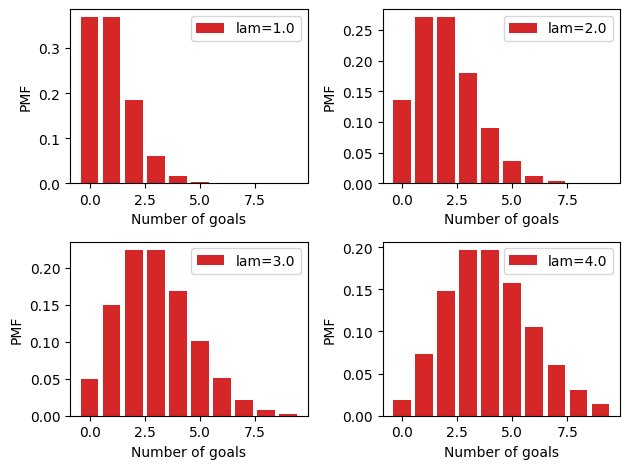

In [50]:
import matplotlib.pyplot as plt

for idx, i in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, idx+1)
    lam = prior.qs[i]
    pmf = pmf_seq[i]
    pmf.bar(label=f'lam={lam}', color='C3')
    decorate_goals()

In [51]:
import pandas as pd

In [52]:
def make_mixture(pmf, pmf_seq):
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [ ]:
'''
The starting point for the mixture is france:
1. First we build out the prior, which is coming from the distribution of lambda itself. This is teh gamma distribution with mean 1.4.
This prior information is qs of lambda.
2. Then we say, for a given lambda this is the poisson distribution. Therefore, with a k=4 value we have a likelihood for every lambda calculated
3. The update is then likelihood * prior.

The approach of the mixture is by starting with probability of selection (in this case, the different lambdas). Because for france we already have a base case.
Then we are mixing with all the possible distributions, this is by creating a distribution for each lambda from the gamma distribution. Basically, lots of potential priors.

"The mixture arises because instead of using a single Poisson(λ), 
we use a weighted sum of Poisson distributions across all possible λ values, 
where each λ is weighted by its posterior probability."

This is all happening because we are asking about the rematch.
Above we deduced the posterior information for france, but in general the lam is remains uncertain.
Therefore, we discretize lam and take a weighted sum using the posterior of france
'''


df = pd.DataFrame(pmf_seq).fillna(0).transpose() # each columns is a lambda value. We have 10 rows because we are stoppping at 10 potential goals.

#then we need to update each of these possible lambda columns with the probability associated to france:
df *= np.array(france) #output of which is the probability of the france lambda, with the probability of the prior lambda. 

#now we need to sum probabilities for each row
pred_france = Pmf(df.sum(axis=1))
pred_france

,probs
0,0.112030
1,0.201777
2,0.215467
3,0.177493
4,0.124612
5,0.078434
6,0.045603
7,0.024969
8,0.013047
9,0.006568


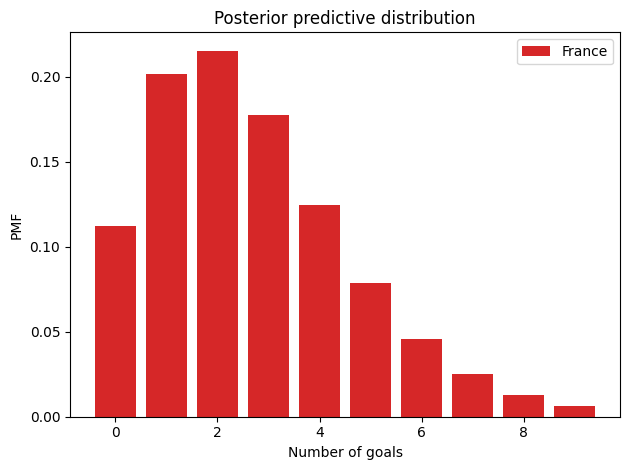

In [73]:
pred_france.bar(color='C3', label='France')
decorate_goals('Posterior predictive distribution')

In [74]:
pred_croatia = make_mixture(croatia, pmf_seq)

In [75]:
win = Pmf.prob_gt(pred_france, pred_croatia)
win

np.float64(0.5703522415934519)

In [76]:
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

np.float64(0.26443376257235873)

In [77]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

np.float64(0.16521399583418947)

In [78]:
win + tie/2

np.float64(0.6529592395105466)

8.7. The Exponential Distribution

In [79]:
def expo_pdf(t, lam):
    return lam * np.exp(-lam * t)

In [81]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

np.float64(25.616650745459093)

In [82]:
def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

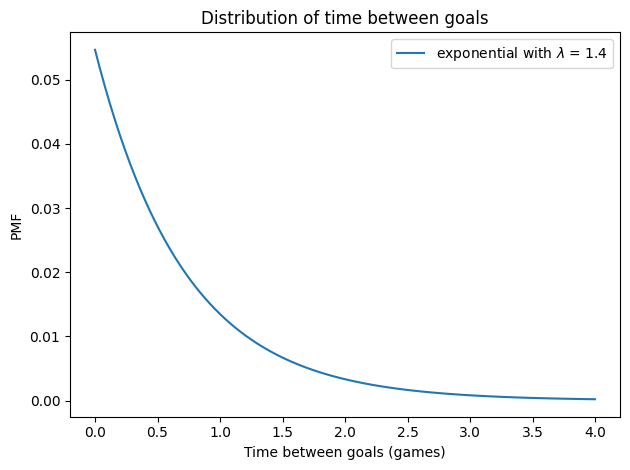

In [83]:
pmf_time.plot(label='exponential with $\lambda$ = 1.4')

decorate_time('Distribution of time between goals')